# RL Trading Bot (Version 1)
### 2022/06/06, AJ Zerouali
### Updated: 2022/06/14

## I - Introduction

This is Section 10 of Lazy Programmer's 1st RL course, which is about stock trading with RL. In these lectures, the instructor uses a linear regression to build an estimator of the Q-function, with an explicit formula for gradient descent with momentum. He's not using neural nets, but I will deviate a little from this.

It is useful to note that the trading bot implemented in these lectures is inspired from the paper Xiao et al. '18, "Practical deep RL for stock trading" (https://arxiv.org/pdf/1811.07522.pdf). This paper uses DDPG for the agent, which we'll do elsewhere.

## II - Simplifying assumptions:

In Lecture 92, Lazy Programmer makes the following simplifying assumptions: 
* We'll consider a portfolio of 3 stocks only.
* The state at a given step will consist of the closing price and the number of shares for each stock, along with the cash available.
* For each stock there will be 3 possible actions: Buy, sell and hold.
* We'll follow an all or nothing approach: If we sell a stock then we sell **all** the shares, and if we buy a stock then we buy **buy as many shares as possible**. The idea is to do this in a *round robin* fashion (loop over stocks and buy until there's no more cash left).
* Sell stocks before buying more.

## Environment

Inspired by OpenAI Gym API. Will use Pandas Datareader elsewhere to download data. Here we'll load the data from CSVs created previously.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as reader
from tensorflow import keras
from datetime import datetime

In [2]:
# These imports are for the standard scaler from sklearn
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

I'll set the start date and end dates below.

#### Questions:
* Length of data should be between 5 and 10 years. Will take 10 years for training data (2010-2019) and 2 years for testing (2020-2021).
* Where does the number of stocks fit?  
* State array has to contain the price of each stock, the no. of shares of each stock, plus current uninvested cash. The environment stores the state. 
* How many tickers and what stocks to consider? Microsoft, Apple, Facebook, Tesla, Samsung, Motorola, Nokia, 

**Trading environment**:
* Attributes: Initial cash; no. of trading days (i.e. length of time series); no. of stocks; arrays of prices

In [3]:
class Trading_Env:
    '''
        Trading environment
    '''
    def __init__(self, df_data, data_start_date, data_end_date, stock_tickers,\
                 n_stocks, ini_cash):
        '''
            Trading environment specified by a dataset and a list of tickers.
            Dataset is a pd.Dataframe of closing prices
            Gives no. of trading days.
            
            Convention for possible actions for an asset: 0 = HOLD, 1 = BUY, 1 = SELL.
            
            State will be described by an array of length 2*(n_stocks)+1.
            
            ARGUMENTS:  - df_data: Pandas DataFrame of training data (5 or 10 years).
                        - data_start_date: Start date of data, datetime.datetime object
                        - data_start_date: End date of data, datetime.datetime object
                        - stock_tickers: List of tickers of stocks
                        - n_stocks: No. of stocks used in the environment
                        - ini_cash: Initial uninvested cash.
            
        '''
        # Data set attributes:
        self.n_data_days = len(df_data) # Length of dataset
        self.data_start_date = data_start_date
        self.data_end_date = data_end_date
        self.stock_tickers = stock_tickers
                
        # Portfolio attributes
        self.n_stocks = n_stocks # No. of stocks used in env
        self.ini_cash = ini_cash # 
        
        # Actions and action space
        self.n_choices = 3 # No. of possible actions for each stock
        self.n_actions = self.n_stocks**self.n_choices
        self.action_space = [i for i in range(self.n_actions)] # Action space (indices)
        self.action_space_arrs = []
        ## Populate action space in array form. Order of array indices corresponds 
        ##  to that of ticker list (self.stock_tickers)
        for i in range(self.n_choices):
            for j in range(self.n_choices):
                for k in range(self.n_choices):
                    self.action_space_arrs.append(np.array([i,j,k], dtype = np.int8))
        
        
        # This time series is the data in np.ndarray format
        ### Note: Clean the data frame df_data to avoid errors, especially if loaded from CSV
        self.time_series = np.zeros(shape = (self.n_data_days, self.n_stocks), dtype = np.float32)
        for i in range(self.n_stocks):
            self.time_series[:,i] = df_data[self.stock_tickers[i]].to_numpy()
        
        # time_index acted upon by reset() and step(). 
        self.time_index = 0
        # Current state array.
        self.state_shape = 2*self.n_stocks+1
        self.state = np.zeros(shape = self.state_shape, dtype=np.int32)
        
    # END DEF __init__()
        
        
    def reset(self):
        '''
            Resets environment to beginning of the dataset (day 1)
            Returns initial state
        '''
        self.time_index = 0
        state = np.zeros(shape = self.state_shape, dtype= np.float32)
        state[0:self.n_stocks] = self.time_series[0]
        state[-1] = self.ini_cash
        self.state = state
        
        return state
    
    # END DEF reset()
    
    # "Execute trades" method. Does the heavy lifting for the step() method
    def exec_trades(self, action):
        '''
            Execute trades given by action in environment.
            In symbols, the arguments are (s_t,a_t, p_(t+1)), where p_(t+1) are
            stock prices of the next day. This method computes the state s_(t+1)
            resulting from (s_t,a_t, p_(t+1)). 
            (Notation: If p_t = (p^1_t, p^2_t, p^3_t) are stocks prices, then
            s_t = (p_t, n_t, c_t) where n_t is the 3-vector of shares and c_t is 
            the available cash.)
            
            ARGUMENT: - action
            OUTPUT: - New state s_(t+1).
            IMPORTANT: This method should be called AFTER the time_index is incremented
                        in the step() method.
        '''
    
        #### CONVENTION: For actions per stock 0 = HOLD; 1 = BUY; 2 = SELL ####

        # Init.
        ini_state = np.copy(self.state)
        new_state = np.copy(self.state)
        '''
        Note: Initially wrote new_state[0:self.n_stocks] = self.time_series[self.time_index+1].
                This method is called after the update self.time_index += 1 in step()
        '''
        new_state[0:self.n_stocks] = self.time_series[self.time_index]

        # Unpack action
        action_arr = self.action_space_arrs[action]

        # Make sell and buy lists
        sell_list = []
        buy_list = []
        #### NOTE: Unless otherwise stated, i is stock index ####
        for i in range(self.n_stocks):
            if action_arr[i] == 1:
                buy_list.append(i)
            elif action_arr[i] == 2:
                sell_list.append(i)

        # Sell assets. Recall: cash = state[-1]
        for i in sell_list:
            # For stock i, update cash by selling new_state[self.n_stocks+i] shares at price new_state[i]
            new_state[-1] += new_state[self.n_stocks+i]*new_state[i]
            # Update no. of share of stock i to 0
            new_state[self.n_stocks+i] = 0

        # Buy shares if buy_list is non empty:
        if len(buy_list) > 0:
            ## Make stop array for while loop
            stop_arr = np.zeros(shape = len(buy_list), dtype = np.bool8)
            ## Initialize boolean array for while loop
            continue_arr = np.ones(shape = len(buy_list), dtype = np.bool8)
            #### NOTE: Always iter over continue_arr with i_list      ####
            ####       Always iter over state with i=buy_list[i_list] ####
            for i_list in range(len(buy_list)): # Can this loop be avoided?
                # Set continue_arr[i_list] = True 
                # if can afford 1 share of stock i = buy_list[i_list]
                continue_arr[i_list] = (new_state[-1] >= new_state[buy_list[i_list]])

            ## Main loop
            i_list = 0
            while not np.array_equal(continue_arr, stop_arr):
                # Init. cash and stock indx
                i = buy_list[i_list]
                cash = np.copy(new_state[-1])

                # Condition
                if continue_arr[i_list] == True:
                    # Buy one share of stock i
                    cash -= new_state[i]
                    new_state[self.n_stocks+i] += 1
                    new_state[-1] = cash

                # Update list index for next iteration
                if i_list == (len(buy_list)-1):
                    i_list = 0
                else:
                    i_list += 1

                # Update continue_arr for next iteration (at next index only)
                continue_arr[i_list] = ( cash >= new_state[buy_list[i_list]] )

        return new_state
    
    # Step method familiar to Gym users. Calls the exec_trades() method above
    def step(self, action):
        '''
            Take action a in environment. Returns s', r, done, info.
            Remark: Calls exec_trades() after incrementing time index.
            
            ARGUMENT: 
            
        ''' 
        # Increment time index
        self.time_index += 1 
        
        # Compute next state (IMPORTANT: This line MUST come after the one above)
        next_state = self.exec_trades(action)
        
        # Compute new portfolio value and assign to info dictionary
        new_portfolio_value = np.dot(next_state[0:self.n_stocks], \
                                     next_state[self.n_stocks:2*self.n_stocks]) + next_state[-1]
                                
        
        # info will just be next portfolio value
        info = {'Portfolio Value':new_portfolio_value} 
        
        # Difference between portfolio values
        reward = new_portfolio_value - np.dot(self.state[0:self.n_stocks], \
                                              self.state[self.n_stocks:2*self.n_stocks]) - self.state[-1]
        # UPDATE ENVIRONMENT STATE 
        self.state = next_state
        
        # Done boolean
        if self.time_index == (self.n_data_days-1):
            done = True
        else:
            done = False
            
        
        
        return next_state, reward, done, info
        
    # END DEF step()    

# END CLASS Trading_Env

## Scaler for dataset

I'm borrowing this from Lazy Programmer's GitHub: https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rl/linear_rl_trader.py.


In [4]:
def build_scaler(env, save_scaler = False, scaler_fname="default_scaler.pkl"):
    '''
        Builds a StandardScaler() for the states of a Trading_Env() object.
        IMPORTANT: Import StandardScaler from sklearn.preprocessing prior to
                   calling this function.
        
        ARGUMENTS: - env: Trading_Env() object.
                   - save_scaler: Boolean for saving.
                   - scaler_fname: 
        OUTPUT: - dataset_scaler: Calibrated sklearn.preprocessing.StandardScaler() object.
        NOTEs: - This function generates an episode using random choices from env.action_space,
                 then fits the StandardScaler() to the resulting list of states.
               - For clarity and future use, include tickers in filename
    '''
    # Instantiate scaler
    dataset_scaler = StandardScaler()
    
    # Init. state list
    state_list = [env.reset()]
    
    # Loop over entire dataset. Create a random episode with random choices
    #for _ in range(env.n_data_days):
    done = False
    while not done:        
        action = np.random.choice(env.action_space)
        next_state, reward, done, info = env.step(action)
        state_list.append(next_state)
        
    # Fit scaler
    dataset_scaler.fit(state_list)
    
    # Save scaler using pickle
    ## Note: Use pickle.dump(obj, open('fname_str.pkl', 'wb')) to save scaler,
    ##       use scaler = pickle.load(open('fname_str.pkl', 'rb')) to load obj.
    if save_scaler:
        # Include env tickers in order in filename
        if scaler_fname == "default_scaler.pkl":
            fname = scaler_fname[:-4]
            fext = scaler_fname[-4:]
            for tckr in env.stock_tickers:
                fname += '_'+tckr
            fname += fext
            scaler_fname = fname
        # Save the scaler        
        dump(dataset_scaler, open(scaler_fname, 'wb'))
    
    return dataset_scaler
# END DEF build_scaler()

## Linear Agent

This part implements a "linear trader", where the Q-function is represented by a shallow network with linear activations only.
This class doesn't implement gradient descent by hand, and uses Keras' training function. Lastly, will not use a batch approach in this class.


In [5]:
class Linear_Trader:
    '''
         Q-function is represented by a shallow network with linear activations only,
         uses Keras' simple SGD fitting function (no batch training).
         Uses a pretrained scaler on the Trading_Env() environment of interest.
    '''
    def __init__(self, env, \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, \
                 
                 scaler,
                 # Filename for model
                 model_fname = "Linear_Trader_001.h5"):
        '''
            Linear trader agent
            ARGUMENTS:  - env: Trading_Environment() object. Gives the action/state space dimensions
                        - learn_rate, gamma, epsilon: Learning hyperparameters
                        - scaler: StandardScaler() from sklearn.preprocessing, previously trained on env dataset.
                        - model_fname: Filename for saving the model
            Note: Called linear trader because the Q-network is an affine transormation of the states.
                  Corresp. attribute is q_net, built by calling build_network() defined below.
        '''
        
        # Learning hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.learn_rate = learn_rate
        
        # Action/State dimensions
        self.n_stocks = env.n_stocks
        self.n_actions = env.n_actions
        self.state_shape = 2*self.n_stocks + 1
        
        # Scaler for states
        self.scaler = scaler
        
        # Q-network
        self.q_net = self.build_net()
        self.model_fname = model_fname
     
    # END DEF __init__()
    
    def build_net(self):
        
        ################################
        ### MAKE SURE THIS WILL WORK ###
        ################################
        
        # Shallow network with parameters (W,b)
        ## Note: Although input_shape = (state_shape, ), TensorFlow 2.7.x+
        ##       will change it to (None, state_shape).
        ##       Pass-in state s as x = np.array([s]) (s scaled).
        lin_model = keras.models.Sequential()
        lin_model.add(keras.layers.Dense(units = self.n_actions, \
                                         input_shape = (self.state_shape, ),\
                                         activation = "linear"))
        lin_model.compile(optimizer = "sgd", loss = "mse")
        
        return lin_model
        
    # END DEF build_net()
    
    def choose_action(self, state):
        """
            Method choosing action in input state following epsilon-greedy policy.
            INPUT: observation (current state)
            OUTPUT: action
        """
        random_no = np.random.uniform(0,1)
        
        if random_no < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            #### IMPORTANT: Modify for scaled states #####
            '''
                Note: About reshaping, I had the following message from sklearn/numpy
                     "Reshape your data either using array.reshape(-1, 1) 
                      if your data has a single feature or array.reshape(1, -1) 
                      if it contains a single sample."
            '''
            # Reshaped state for scaler
            state_ = self.scaler.transform(state.reshape(1, -1))
            #state_ = np.array([self.scaler.transform(s)])
            q_eval = self.q_net.predict(state_) # Check if you need to add [0] at the end.
            action = np.argmax(q_eval)
            
        return action
        
    # END DEF choose_action()
    
    # Training method. Takes in more arguments since we're not using a 
    # replay buffer for batches.
    def train_net(self, state, action, reward, next_state, done,\
                  N_steps=0, ep_i=0, notify_end_train=False):
        '''
            Training method for linear trader. Executes on SGD descent step on scalars.
            Most parameters are outputs of env.Step() method.
            
            ARGUMENTS: - state, action, reward, next_state: (s,a,r,s') transition tuple.
                       - done: Boolean designating end of episode.
                       - N_steps, ep_i, notify_end_train: Debug parameters for printing.
        '''
        
        ################################################################
        ### MAKE SURE THIS WILL WORK ###
        ### Might be useful to debug as a function outside the class
        ################################################################
        
        # Scale the arguments and format
        '''
        state_ = np.array([self.scaler.transform(state)])
        next_state_ = np.array([self.scaler.transform(next_state)])
        '''
        state_ = self.scaler.transform(state.reshape(1,-1))
        next_state_ = self.scaler.transform(next_state.reshape(1,-1))
        
        ################################################################
        ### NOTE: This is consistent with the implementation of 
        ###       Trading_Env.step(). The done flag is true when
        ###       env.time_index = env.n_data_days, which occurs
        ###       when next_state is terminal.
        ################################################################
        
        # Q-value estimates
        q_eval = self.q_net.predict(state_)
        q_next = self.q_net.predict(next_state_)
        
        # TD target(be careful if done=True)
        y = reward +self.gamma*np.max(q_next)*(1-int(done))
        
        # Target vector for q_net
        q_target = np.copy(q_eval)
        '''
        NOTE: Beware of input_shape produced by TensorFlow 2.7+. When building network
              we specified input_shape = (self.state_shape,), but TF2 changes it to 
              (None, self.state_shape). Likewise, the output shape is (None, env.n_actions)
              when specifying env.n_actions neurons in the layer.
        '''
        q_target[0, action] = y
        
        # Fit the network using keras.models.Sequential.fit(x,y, batch_size = 32, epochs=10)
        self.q_net.fit(state_, q_target, batch_size =1, verbose = 0)
        
    # END DEF train_net()
    
    def save_model(self):
        self.q_net.save(self.model_fname)
    # END DEF save_model()
    
    def load_model(self, ext_model_fname):
        self.q_net = keras.models.load_model(ext_model_fname)
    # END DEF load_model()
    
# END CLASS Linear_Trader    
    
    

In [10]:
help(keras.models.load_model)

Help on function load_model in module tensorflow.python.keras.saving.save:

load_model(filepath, custom_objects=None, compile=True, options=None)
    Loads a model saved via `model.save()`.
    
    Usage:
    
    >>> model = tf.keras.Sequential([
    ...     tf.keras.layers.Dense(5, input_shape=(3,)),
    ...     tf.keras.layers.Softmax()])
    >>> model.save('/tmp/model')
    >>> loaded_model = tf.keras.models.load_model('/tmp/model')
    >>> x = tf.random.uniform((10, 3))
    >>> assert np.allclose(model.predict(x), loaded_model.predict(x))
    
    Note that the model weights may have different scoped names after being
    loaded. Scoped names include the model/layer names, such as
    `"dense_1/kernel:0"`. It is recommended that you use the layer properties to
    access specific variables, e.g. `model.get_layer("dense_1").kernel`.
    
    Args:
        filepath: One of the following:
            - String or `pathlib.Path` object, path to the saved model
            - `h5py.File

## Training algorithm

This is the code for the training file. There will be a separate one for testing.
As mentioned above, we first train our linear agent on a dataset of 3 stocks over a period of 10 years, from 2010-01-01 to 2019-12-31.


In [3]:
# Training data start and end dates
data_training_start = datetime(2010, 1, 1)
data_training_end = datetime(2019, 12, 31)

2010-01-01 00:00:00


In [4]:
df_data =pd.read_csv("Training_DataSet_01_AdjClose.csv", usecols = ["AAPL", "AMZN", "JNJ"])

In [5]:
df_data

,AAPL,AMZN,JNJ
0,6.535086,6.695000,44.863743
1,6.546385,6.734500,44.343533
2,6.442255,6.612500,44.704216
3,6.430344,6.500000,44.385155
4,6.473097,6.676000,44.537754
...,...,...,...
2511,69.835594,89.460503,136.812378
2512,71.221161,93.438499,136.718643
2513,71.194122,93.489998,136.643661
2514,71.616684,92.344498,136.221786


In [17]:
'''
#################################################
### LINEAR TRADING AGENT - TRAINING ALGORITHM ###
#################################################
## 2022/06/10; Ahmed J Zerouali
### Updated: 2022/06/10
# This is the training 
## 

# Header
from __future__ import print_function, division
from builtins import range

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as reader
from tensorflow import keras
from datetime import datetime

# These imports are for the standard scaler from sklearn
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

# Import trading environment, "linear RL trader" and scaler construction f'n
from Linear_RL_Trader import Trading_Env, Linear_Trader, build_scaler

'''
# if name=="__main__":
# Training algorithm: Part 1 - Initializations
if True:
    ###########################
    ##### INITIALIZATIONS #####
    ###########################
    
    # Number of training episodes
    n_episodes = 1
    
    # Init. Deep RL hyperparameters:
    learn_rate = 0.01
    gamma = 0.99
    epsilon = 0.1
    
    # Init. filenames
    ### NOTE: Modify filenames to not overwrite
    model_fname = 'Linear_Trader_AMZN_JPM_INTC_220610.h5'
    scaler_fname = 'Lin_Trader_Scaler_AMZN_JPM_INTC_220610.pkl'
    portfolio_returns_fname = "Returns_Hist_AMZN_JPM_INTC_220610.csv"
    portfolio_values_fname = "Values_Hist_AMZN_JPM_INTC_220610.csv"
    
    # Ticker list
    '''
    NOTE: This is very important. I intend to test the 
          trading bot on the years 2020 and 2021. I'll
          take 'AMZN' (steady growth on test period),
          'JPM' (hit pretty hard in 2020), and Intel
          'INTC' which had several ups and downs.
          The latter had the worst dip in March 2020.
    '''
    ticker_list = ['AMZN', 'JPM', 'INTC']
    
    # Training set dates
    data_training_start = datetime(2010, 1, 1)
    data_training_end = datetime(2019, 12, 31)
    
    # Load dataset
    df_train_data = pd.read_csv("Training_DataSet_01_AdjClose.csv", usecols = ticker_list)
    
    # Instantiate environment
    '''
    def __init__(self, df_data, data_start_date, data_end_date, stock_tickers,\
                 n_stocks, ini_cash):
    '''
    env = Trading_Env(df_data=df_train_data,\
                      data_start_date=data_training_start,\
                      data_end_date=data_training_end, \
                      stock_tickers=ticker_list,\
                      n_stocks = 3, ini_cash = 5000.0)
    
    # Build scaler and save file
    ## The scaler resets the environment in the beginning
    scaler_AMZN_JPM_INTC = build_scaler(env, save_scaler=True, scaler_fname = scaler_fname)
    
        # Instantiate linear agent
    ## Note: The constructor initializes the Q-network weights
    '''
        def __init__(self, env, \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, \
                 scaler,
                 # Filename for model
                 model_fname = "Linear_Trader_001.h5"):
    '''
    env.reset()
    agent = Linear_Trader(env, learn_rate = learn_rate, gamma = gamma, epsilon = epsilon,\
                          scaler=scaler_AMZN_JPM_INTC, model_fname=model_fname)
    
    # Portfolio returns
    portfolio_returns_hist = []
    portfolio_values_hist = []
    
    # Init. timer of main loop
    training_begin_time = datetime.now()
    
    #####################
    ##### MAIN LOOP #####
    #####################
    
    print("Starting main loop...")
    # Loop over episodes:
    for episode_cntr in range(n_episodes):
        
        # Init. episode
        done = False
        portfolio_return = 0.0
        state = env.reset()
        
        # Loop over steps in episodes
        while not done:
            
            # Choose an action (following epsilon-greedy)
            action = agent.choose_action(state)
            # Get reward and next state
            next_state, reward, done, info = env.step(action)
            # Update score
            portfolio_return += reward
            
            '''
            train_net(self, state, action, reward, next_state, done,\
                  N_steps=0, ep_i=0, notify_end_train=False):
            '''
            # Train the model
            agent.train_net(state, action, reward, next_state, done)
            # Update state
            state = next_state
                
            # Append portfolio return and value
            portfolio_returns_hist.append(portfolio_return)
            portfolio_values_hist.append(info['Portfolio Value'])
            
        # END while over episode steps

    # END OF MAIN DQN LOOP (i over episodes) 
    print("Exited main loop.")
    
    # Exec time of main loop
    training_exec_time = datetime.now()-training_begin_time
    
    ###################################
    ##### REPORT AND RESULT FILES #####
    ###################################
    
    # New
    print(f"Writing report and portfolio histories...")
    
    # Save portfolio returns history into a CSV (using Pandas)
    ### NOTE: Modify the code below to clean-out output
    df_returns = pd.DataFrame(portfolio_returns_hist, columns = ['Returns'])
    df_returns.to_csv(portfolio_returns_fname)
    # Compute mean, min and max of scores, added to report below.
    returns_mean = df_returns["Returns"].mean()
    returns_max = df_returns["Returns"].max()
    returns_min = df_returns["Returns"].min()
    # Save portfolio values history into a CSV
    df_values = pd.DataFrame(portfolio_values_hist, columns = ['Portfolio Values'])
    df_values.to_csv(portfolio_values_fname)

    # Save trained DQN model:
    agent.save_model()
    print(f"Saved linear model parameters under {model_fname}")

    # Report file open
    fname_time = datetime.now()
    report_fname = "Report_Lin_Trader_"\
                    +str(fname_time.year-2000)+str(fname_time.month)+str(fname_time.day)\
                    +str(fname_time.hour)+str(fname_time.minute)+".txt"
    report_file = open(report_fname, mode = "w+")
    # Title
    report_file.write(f"Linear trading agent - {fname_time}:\n")
    # Write report to file
    report_file.write(f"- Execution over {n_episodes} episodes over steps completed.\n")
    report_file.write(f"- Data tickers: {ticker_list}.\n")
    report_file.write(f"- Training data start date: {data_training_start}.\n")
    report_file.write(f"- Training data end date: {data_training_end}.\n")
    report_file.write(f"- Total training time: {training_exec_time}.\n")
    report_file.write(f"- Average return: {returns_mean}.\n")
    report_file.write(f"- Highest return: {returns_max}.\n")
    report_file.write(f"- Lowest return: {returns_min}.\n")
    report_file.write(f"- DRL Hypeparameters: * learn_rate = {learn_rate},\n")
    report_file.write(f"                      * gamma = {gamma},\n")
    report_file.write(f"                      * epsilon = {epsilon},\n")
    report_file.write(f"                      * Saved model filename = {model_fname}.\n")
    # Close report file
    report_file.close()

Starting main loop...
Exited main loop.
Writing report and portfolio histories...
Saved DQN model parameters under Linear_Trader_AMZN_JPM_INTC_220610.h5


<AxesSubplot:>

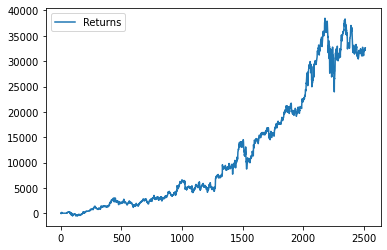

In [18]:
df_returns.plot()

<AxesSubplot:>

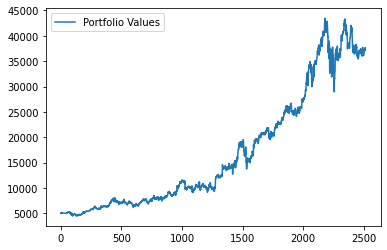

In [19]:
df_values.plot()

## Testing algorithm

To test the model trained above, we use:

* Stock price histories from 2020-01-01 to 2021-12-31 (as with the training data, the CSV files are created elsewhere).

* The scaler and the weights obtained from the training process.


### Verifying files

This is to check that the training data is loaded properly and that the StandardScaler works.

In [10]:
df_temp = pd.read_csv("Testing_DataSet_01_AdjClose.csv", usecols = ['AMZN', 'JPM', 'INTC'])
df_temp

,AMZN,JPM,INTC
0,94.900497,131.047989,56.975693
1,93.748497,129.318619,56.282696
2,95.143997,129.215790,56.123493
3,95.343002,127.019043,55.187008
4,94.598503,128.009918,55.224464
...,...,...,...
500,169.669495,156.060837,51.143055
501,170.660995,156.534454,50.965816
502,169.201004,156.455521,51.034748
503,168.644501,156.376587,50.946129


In [11]:
len(df_temp)

505

In [7]:
temp_scaler_fname = "Lin_Trader_Scaler_AMZN_JPM_INTC_220610.pkl"

In [5]:
help(load)

Help on built-in function load in module _pickle:

load(file, *, fix_imports=True, encoding='ASCII', errors='strict', buffers=())
    Read and return an object from the pickle data stored in a file.
    
    This is equivalent to ``Unpickler(file).load()``, but may be more
    efficient.
    
    The protocol version of the pickle is detected automatically, so no
    protocol argument is needed.  Bytes past the pickled object's
    representation are ignored.
    
    The argument *file* must have two methods, a read() method that takes
    an integer argument, and a readline() method that requires no
    arguments.  Both methods should return bytes.  Thus *file* can be a
    binary file object opened for reading, an io.BytesIO object, or any
    other custom object that meets this interface.
    
    Optional keyword arguments are *fix_imports*, *encoding* and *errors*,
    which are used to control compatibility support for pickle stream
    generated by Python 2.  If *fix_imports* i

In [8]:
temp_scaler = load(open(temp_scaler_fname, "rb"))

In [9]:
type(temp_scaler)

sklearn.preprocessing._data.StandardScaler

In [12]:
'''
######################################
### LINEAR TRADING AGENT - TESTING ###
######################################
## 2022/06/14; Ahmed J Zerouali
### Updated: 2022/06/14
# This is the testing script for the linear trader.
## 

# Header
from __future__ import print_function, division
from builtins import range

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from datetime import datetime

# These imports are for the standard scaler from sklearn
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

# Import trading environment, "linear RL trader" and scaler construction f'n
from Linear_RL_Trader import Trading_Env, Linear_Trader, build_scaler

'''
# if name=="__main__":
# Training algorithm: Part 1 - Initializations
if True:
    ###########################
    ##### INITIALIZATIONS #####
    ###########################
    
    # Number of episodes
    n_episodes = 1
    
    # Init. Deep RL hyperparameters:
    learn_rate = 0.01
    gamma = 0.99
    epsilon = 0.1
    
    # Init. filenames
    ### NOTE: Modify filenames to not overwrite
    model_fname = 'Linear_Trader_AMZN_JPM_INTC_220610.h5' 
    scaler_fname = 'Lin_Trader_Scaler_AMZN_JPM_INTC_220610.pkl'
    portfolio_returns_fname = "TEST_Returns_AMZN_JPM_INTC_220610.csv"
    portfolio_values_fname = "TEST_Values_AMZN_JPM_INTC_220610.csv"
    
    # Ticker list
    '''
    NOTE: Should be tested on other tickers
    '''
    ticker_list = ['AMZN', 'JPM', 'INTC']
    
    # Testing set dates
    data_testing_start = datetime(2020, 1, 1)
    data_testing_end = datetime(2021, 12, 31)
    
    # Load dataset
    df_test_data = pd.read_csv("Testing_DataSet_01_AdjClose.csv", usecols = ticker_list)
    
    # Instantiate environment
    '''
    def __init__(self, df_data, data_start_date, data_end_date, stock_tickers,\
                 n_stocks, ini_cash):
    '''
    env = Trading_Env(df_data=df_test_data,\
                      data_start_date=data_testing_start,\
                      data_end_date=data_testing_end, \
                      stock_tickers=ticker_list,\
                      n_stocks = 3, ini_cash = 5000.0)
    
    # Load trained scaler 
    scaler_AMZN_JPM_INTC = load(open(scaler_fname, "rb"))
    
    # Instantiate linear agent and load trained linear model
    '''
        def __init__(self, env, \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, \
                 scaler,
                 # Filename for model
                 model_fname = "Linear_Trader_001.h5"):
    '''
    env.reset()
    
    agent = Linear_Trader(env, learn_rate = learn_rate, gamma = gamma, epsilon = epsilon,\
                          scaler=scaler_AMZN_JPM_INTC)
    agent.load_model(model_fname)
    
    # Portfolio returns
    portfolio_returns_hist = []
    portfolio_values_hist = []
    
    # Init. timer of main loop
    testing_begin_time = datetime.now()
    
    #####################
    ##### MAIN LOOP #####
    #####################
    
    print("Starting main loop...")
    # Loop over episodes:
    for episode_cntr in range(n_episodes):
        
        # Init. episode
        done = False
        portfolio_return = 0.0
        state = env.reset()
        
        # Loop over steps in episodes
        while not done:
            
            # Choose an action (following epsilon-greedy)
            action = agent.choose_action(state) # Review the policy implemented in the agent
            # Get reward and next state
            next_state, reward, done, info = env.step(action)
            # Update score
            portfolio_return += reward
            # Update state
            state = next_state
                
            # Append portfolio return and value
            portfolio_returns_hist.append(portfolio_return)
            portfolio_values_hist.append(info['Portfolio Value'])
            
        # END while over episode steps

    # END OF MAIN TESTING LOOP (i over episodes) 
    print("Exited main loop.")
    
    # Exec time of main loop
    testing_exec_time = datetime.now()-testing_begin_time
    
    ###################################
    ##### REPORT AND RESULT FILES #####
    ###################################
    
    # New
    print(f"Writing report and portfolio histories...")
    
    # Save portfolio returns history into a CSV (using Pandas)
    ### NOTE: Modify the code below to clean-out output
    df_returns = pd.DataFrame(portfolio_returns_hist, columns = ['Returns'])
    df_returns.to_csv(portfolio_returns_fname)
    # Compute mean, min and max of scores, added to report below.
    returns_mean = df_returns["Returns"].mean()
    returns_max = df_returns["Returns"].max()
    returns_min = df_returns["Returns"].min()
    # Save portfolio values history into a CSV
    df_values = pd.DataFrame(portfolio_values_hist, columns = ['Portfolio Values'])
    df_values.to_csv(portfolio_values_fname)

    # Report file open
    fname_time = datetime.now()
    report_fname = "TEST_Rprt_Lin_Trader_"\
                    +str(fname_time.year-2000)+str(fname_time.month)+str(fname_time.day)\
                    +str(fname_time.hour)+str(fname_time.minute)+".txt"
    report_file = open(report_fname, mode = "w+")
    # Title
    report_file.write(f"Linear trading agent TEST MODE - {fname_time}:\n")
    # Write report to file
    report_file.write(f"- Execution over {n_episodes} episodes of {len(df_values)} days.\n")
    report_file.write(f"- Weights of Linear Trader used: {model_fname}.\n")
    report_file.write(f"- Data tickers: {ticker_list}.\n")
    report_file.write(f"- Test data start date: {data_testing_start}.\n")
    report_file.write(f"- Test data end date: {data_testing_end}.\n")
    report_file.write(f"- Total runtime: {testing_exec_time}.\n")
    report_file.write(f"- Average return: {returns_mean}.\n")
    report_file.write(f"- Highest return: {returns_max}.\n")
    report_file.write(f"- Lowest return: {returns_min}.\n")
    report_file.write(f"- DRL Hypeparameters: * learn_rate = {learn_rate},\n")
    report_file.write(f"                      * gamma = {gamma},\n")
    report_file.write(f"                      * epsilon = {epsilon},\n")
    # Close report file
    report_file.close()

Starting main loop...
Exited main loop.
Writing report and portfolio histories...


<AxesSubplot:>

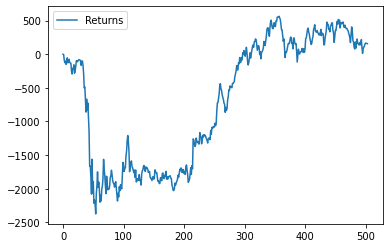

In [13]:
df_returns.plot()

A really bad first performance...

### Using optimal actions

The previous test used the $\varepsilon$-greedy policy to compute the actions. The code below doesn't call the choose_action() method of the agent, and instead computes the optimal action.

In [6]:
def argmax_policy(agent, state):
    '''
        Function that computes optimal action from a trained (linear) Q-network.
        ARGUMENTS: - agent: Linear_Trader() object with trained Q-network
                   - state: Current state to evaluate Q-value
        OUTPUT:    - action: Action that is the argmax of the Q-values.
    '''
    state_ = agent.scaler.transform(state.reshape(1,-1))
    q_eval = agent.q_net.predict(state_)
    action = np.argmax(q_eval)
    
    return action

In [7]:
'''
######################################
### LINEAR TRADING AGENT - TESTING ###
######################################
## 2022/06/14; Ahmed J Zerouali
### Updated: 2022/06/14
# This is the testing script for the linear trader.
## 

# Header
from __future__ import print_function, division
from builtins import range

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from datetime import datetime

# These imports are for the standard scaler from sklearn
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

# Import trading environment, "linear RL trader" and scaler construction f'n
from Linear_RL_Trader import Trading_Env, Linear_Trader, build_scaler

'''
# if name=="__main__":
# Training algorithm: Part 1 - Initializations
if True:
    ###########################
    ##### INITIALIZATIONS #####
    ###########################
    
    # Number of episodes
    n_episodes = 1
    
    # Init. Deep RL hyperparameters:
    learn_rate = 0.01
    gamma = 0.99
    epsilon = 0.1
    
    # Init. filenames
    ### NOTE: Modify filenames to not overwrite
    model_fname = 'Linear_Trader_AMZN_JPM_INTC_220610.h5' 
    scaler_fname = 'Lin_Trader_Scaler_AMZN_JPM_INTC_220610.pkl'
    portfolio_returns_fname = "TEST_Returns_AMZN_JPM_INTC_220610.csv"
    portfolio_values_fname = "TEST_Values_AMZN_JPM_INTC_220610.csv"
    
    # Ticker list
    '''
    NOTE: Should be tested on other tickers
    '''
    ticker_list = ['AMZN', 'JPM', 'INTC']
    
    # Testing set dates
    data_testing_start = datetime(2020, 1, 1)
    data_testing_end = datetime(2021, 12, 31)
    
    # Load dataset
    df_test_data = pd.read_csv("Testing_DataSet_01_AdjClose.csv", usecols = ticker_list)
    
    # Instantiate environment
    '''
    def __init__(self, df_data, data_start_date, data_end_date, stock_tickers,\
                 n_stocks, ini_cash):
    '''
    env = Trading_Env(df_data=df_test_data,\
                      data_start_date=data_testing_start,\
                      data_end_date=data_testing_end, \
                      stock_tickers=ticker_list,\
                      n_stocks = 3, ini_cash = 5000.0)
    
    # Load trained scaler 
    scaler_AMZN_JPM_INTC = load(open(scaler_fname, "rb"))
    
    # Instantiate linear agent and load trained linear model
    '''
        def __init__(self, env, \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, \
                 scaler,
                 # Filename for model
                 model_fname = "Linear_Trader_001.h5"):
    '''
    env.reset()
    
    agent = Linear_Trader(env, learn_rate = learn_rate, gamma = gamma, epsilon = epsilon,\
                          scaler=scaler_AMZN_JPM_INTC)
    agent.load_model(model_fname)
    
    # Portfolio returns
    portfolio_returns_hist = []
    portfolio_values_hist = []
    
    # Init. timer of main loop
    testing_begin_time = datetime.now()
    
    #####################
    ##### MAIN LOOP #####
    #####################
    
    print("Starting main loop...")
    # Loop over episodes:
    for episode_cntr in range(n_episodes):
        
        # Init. episode
        done = False
        portfolio_return = 0.0
        state = env.reset()
        
        # Loop over steps in episodes
        while not done:
            
            # Choose an action (using argmax of Q-values)
            action = argmax_policy(agent, state)
            # Get reward and next state
            next_state, reward, done, info = env.step(action)
            # Update score
            portfolio_return += reward
            # Update state
            state = next_state
                
            # Append portfolio return and value
            portfolio_returns_hist.append(portfolio_return)
            portfolio_values_hist.append(info['Portfolio Value'])
            
        # END while over episode steps

    # END OF MAIN TESTING LOOP (i over episodes) 
    print("Exited main loop.")
    
    # Exec time of main loop
    testing_exec_time = datetime.now()-testing_begin_time
    
    ###################################
    ##### REPORT AND RESULT FILES #####
    ###################################
    
    # New
    print(f"Writing report and portfolio histories...")
    
    # Save portfolio returns history into a CSV (using Pandas)
    ### NOTE: Modify the code below to clean-out output
    df_returns = pd.DataFrame(portfolio_returns_hist, columns = ['Returns'])
    df_returns.to_csv(portfolio_returns_fname)
    # Compute mean, min and max of scores, added to report below.
    returns_mean = df_returns["Returns"].mean()
    returns_max = df_returns["Returns"].max()
    returns_min = df_returns["Returns"].min()
    # Save portfolio values history into a CSV
    df_values = pd.DataFrame(portfolio_values_hist, columns = ['Portfolio Values'])
    df_values.to_csv(portfolio_values_fname)

    # Report file open
    fname_time = datetime.now()
    report_fname = "TEST_Rprt_Lin_Trader_"\
                    +str(fname_time.year-2000)+str(fname_time.month)+str(fname_time.day)\
                    +str(fname_time.hour)+str(fname_time.minute)+".txt"
    report_file = open(report_fname, mode = "w+")
    # Title
    report_file.write(f"Linear trading agent TEST MODE - {fname_time}:\n")
    # Write report to file
    report_file.write(f"- Execution over {n_episodes} episodes of {len(df_values)} days.\n")
    report_file.write(f"- Weights of Linear Trader used: {model_fname}.\n")
    report_file.write(f"- Data tickers: {ticker_list}.\n")
    report_file.write(f"- Test data start date: {data_testing_start}.\n")
    report_file.write(f"- Test data end date: {data_testing_end}.\n")
    report_file.write(f"- Total runtime: {testing_exec_time}.\n")
    report_file.write(f"- Average return: {returns_mean}.\n")
    report_file.write(f"- Highest return: {returns_max}.\n")
    report_file.write(f"- Lowest return: {returns_min}.\n")
    report_file.write(f"- DRL Hypeparameters: * learn_rate = {learn_rate},\n")
    report_file.write(f"                      * gamma = {gamma},\n")
    report_file.write(f"                      * epsilon = {epsilon},\n")
    # Close report file
    report_file.close()

Starting main loop...
Exited main loop.
Writing report and portfolio histories...


<AxesSubplot:>

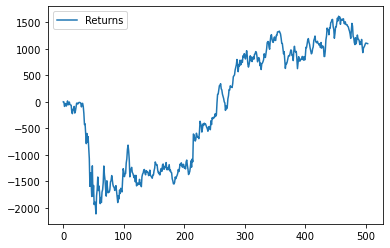

In [8]:
df_returns.plot()

This agent still gets obliterated during 2020, and doesn't even recover the initial cash. Sad AF.

## Training Algorithm - Scrap

### Training Algorithm - Part 1

In [6]:
'''
#################################################
### LINEAR TRADING AGENT - TRAINING ALGORITHM ###
#################################################
## 2022/06/10; Ahmed J Zerouali
### Updated: 2022/06/10
# This is the training 
## 

# Header
from __future__ import print_function, division
from builtins import range

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as reader
from tensorflow import keras
from datetime import datetime

# These imports are for the standard scaler from sklearn
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

# Import trading environment, "linear RL trader" and scaler construction f'n
from Linear_RL_Trader import Trading_Env, Linear_Trader, build_scaler

'''
# if name=="__main__":
# Training algorithm: Part 1 - Initializations
if True:
    # Number of training episodes
    n_episodes = 1
    
    # Init. Deep RL hyperparameters:
    learn_rate = 0.01
    gamma = 0.99
    epsilon = 0.1
    
    # Init. filenames
    ### NOTE: Modify filenames to not overwrite
    model_fname = 'Linear_Trader_AMZN_JPM_INTC_220610.h5'
    scaler_fname = 'Lin_Trader_Scaler_AMZN_JPM_INTC_220610.pkl'
    portfolio_returns_fname = "Returns_Hist_AMZN_JPM_INTC_220610.csv"
    portfolio_values_fname = "Values_Hist_AMZN_JPM_INTC_220610.csv"
    
    # Ticker list
    '''
    NOTE: This is very important. I intend to test the 
          trading bot on the years 2020 and 2021. I'll
          take 'AMZN' (steady growth on test period),
          'JPM' (hit pretty hard in 2020), and Intel
          'INTC' which had several ups and downs.
          The latter had the worst dip in March 2020.
    '''
    ticker_list = ['AMZN', 'JPM', 'INTC']
    
    # Training set dates
    data_training_start = datetime(2010, 1, 1)
    data_training_end = datetime(2019, 12, 31)
    
    # Load dataset
    df_train_data = pd.read_csv("Training_DataSet_01_AdjClose.csv", usecols = ticker_list)
    
    # Instantiate environment
    '''
    def __init__(self, df_data, data_start_date, data_end_date, stock_tickers,\
                 n_stocks, ini_cash):
    '''
    env = Trading_Env(df_data=df_train_data,\
                      data_start_date=data_training_start,\
                      data_end_date=data_training_end, \
                      stock_tickers=ticker_list,\
                      n_stocks = 3, ini_cash = 5000.0)
    
    # Build scaler and save file
    ## The scaler resets the environment in the beginning
    scaler_AMZN_JPM_INTC = build_scaler(env, save_scaler=True, scaler_fname = scaler_fname)
    
    


### Training Algorithm - Part 1

In [8]:
# Training algorithm: Part 2 - Agent and main loop
if True:
    # Instantiate linear agent
    ## Note: The constructor initializes the Q-network weights
    '''
        def __init__(self, env, \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, \
                 scaler,
                 # Filename for model
                 model_fname = "Linear_Trader_001.h5"):
    '''
    env.reset()
    agent = Linear_Trader(env, learn_rate = learn_rate, gamma = gamma, epsilon = epsilon,\
                          scaler=scaler_AMZN_JPM_INTC, model_fname= model_fname)
    
    # Portfolio returns
    portfolio_returns_hist = []
    portfolio_values_hist = []
    
    # Init. timer of main loop
    training_begin_time = datetime.now()
    
    print("Starting main loop...")
    # Loop over episodes:
    for episode_cntr in range(n_episodes):
        
        # Init. episode
        done = False
        portfolio_return = 0.0
        state = env.reset()
        
        # Loop over steps in episodes
        while not done:
            
            # Choose an action (following epsilon-greedy)
            action = agent.choose_action(state)
            # Get reward and next state
            next_state, reward, done, info = env.step(action)
            # Update score
            portfolio_return += reward
            
            '''
            train_net(self, state, action, reward, next_state, done,\
                  N_steps=0, ep_i=0, notify_end_train=False):
            '''
            # Train the model
            agent.train_net(state, action, reward, next_state, done)
            # Update state
            state = next_state
                
            # Append portfolio return and value
            portfolio_returns_hist.append(portfolio_return)
            portfolio_values_hist.append(info['Portfolio Value'])
            
        # END while over episode steps

    # END OF MAIN DQN LOOP (i over episodes) 
    print("Exited main loop.")
    
    # Exec time of main loop
    training_exec_time = datetime.now()-training_begin_time

Starting main loop...
Exited main loop.


#### Training Part 2 debug

In [38]:
state = env.reset()

In [39]:
agent = Linear_Trader(env, learn_rate = learn_rate, gamma = gamma, epsilon = epsilon,\
                          scaler=scaler_AMZN_JPM_INTC, model_fname=model_fname)

In [40]:
agent.q_net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 27)                216       
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________


In [22]:
type(scaler_AMZN_JPM_INTC)

sklearn.preprocessing._data.StandardScaler

In [30]:
s = state.reshape(1, -1)

In [31]:
s.shape

(1, 7)

In [25]:
s

array([[   6.695   ,   31.292093,   14.35307 ,    0.      ,    0.      ,
           0.      , 5000.      ]], dtype=float32)

In [32]:
y = agent.q_net.predict(s)
print(y)

[[-1516.6075    -756.3926    1640.9608     111.135414  1085.4803
    683.68304    767.20074    949.351     1042.2288    -648.90967
   -320.77634  -1222.0979     266.6899   -1113.4485    1168.9121
  -1025.9003    -925.54425   1321.2301    -283.69086    854.8762
   1879.3054    1349.2998   -2015.4843   -1150.6835    1280.0677
   1651.6409    1882.1427  ]]


In [33]:
a = agent.choose_action(state)

In [35]:
a = np.argmax(y)

In [42]:
a

26

In [43]:
# start anew
state = env.reset()


In [44]:
# choose some action
action = agent.choose_action(state)

In [45]:
# take one step in the environment
next_state, reward, done, info = env.step(action)

In [51]:
self = agent

In [55]:
# Write the SGD lines here
#self = agent

if True:
    if True:
        
        # Scale and reshape the vectors
        state_ = self.scaler.transform(state.reshape(1,-1))
        next_state_ = self.scaler.transform(next_state.reshape(1,-1))
        
        # Q-value estimates
        q_eval = self.q_net.predict(state_)
        q_next = self.q_net.predict(next_state_)
        
        # TD target(be careful if done=True)
        y = reward +self.gamma*np.max(q_next)*(1-int(done))
        
        # Target vector for q_net
        q_target = np.copy(q_eval)
        
        q_target[0, action] = y
        
        # Fit the network using keras.models.Sequential.fit(x,y, batch_size = 32, epochs=10)
        self.q_net.fit(state_, q_target, batch_size =1)

1/1 [==============================] - 0s 366ms/step - loss: 1.2766e-06


In [52]:
type(self)

__main__.Linear_Trader

In [54]:
self.q_net.predict(state_)

array([[ 0.13210428, -1.0274603 , -1.0875236 , -0.9947315 , -0.33344615,
        -0.39982942,  0.5237755 ,  0.27439788,  0.18765172,  0.1442462 ,
         0.00143705,  0.6538875 , -0.33529076,  0.29399344,  0.85255927,
        -0.39713565,  0.07512357, -0.28237015, -0.20032835,  0.16064115,
         0.23555657,  0.41537416, -0.24229307, -0.32474297,  0.8791065 ,
         0.31413463, -0.26585057]], dtype=float32)

In [9]:
# Exec time of main loop
training_exec_time = datetime.now()-training_begin_time

In [11]:
print(training_exec_time)

0:05:39.994000


In [14]:
# Training algorithm: Part 3 - Report
if True:
    # New
    print(f"Writing report and portfolio histories...")
    

    # Save portfolio returns history into a CSV (using Pandas)
    ### NOTE: Modify the code below to clean-out output
    df_returns = pd.DataFrame(portfolio_returns_hist, columns = ['Returns'])
    df_returns.to_csv(portfolio_returns_fname)
    # Compute mean, min and max of scores, added to report below.
    returns_mean = df_returns["Returns"].mean()
    returns_max = df_returns["Returns"].max()
    returns_min = df_returns["Returns"].min()
    # Save portfolio values history into a CSV
    df_values = pd.DataFrame(portfolio_values_hist, columns = ['Portfolio Values'])
    df_values.to_csv(portfolio_values_fname)

    # Save trained DQN model:
    agent.save_model()
    print(f"Saved DQN model parameters under {model_fname}")

    # Report file open
    fname_time = datetime.now()
    report_fname = "Report_Lin_Trader"\
                    +str(fname_time.year-2000)+str(fname_time.month)+str(fname_time.day)\
                    +str(fname_time.hour)+str(fname_time.minute)+".txt"
    report_file = open(report_fname, mode = "w+")
    # Title
    report_file.write(f"Linear trading agent - {fname_time}:\n")
    # Write report to file
    report_file.write(f"- Execution over {n_episodes} episodes over steps completed.\n")
    report_file.write(f"- Data tickers: {ticker_list}.\n")
    report_file.write(f"- Training data start date: {data_training_start}.\n")
    report_file.write(f"- Training data end date: {data_training_end}.\n")
    report_file.write(f"- Total training time: {training_exec_time}.\n")
    report_file.write(f"- Average return: {returns_mean}.\n")
    report_file.write(f"- Highest return: {returns_max}.\n")
    report_file.write(f"- Lowest return: {returns_min}.\n")
    report_file.write(f"- DRL Hypeparameters: * learn_rate = {learn_rate},\n")
    report_file.write(f"                      * gamma = {gamma},\n")
    report_file.write(f"                      * epsilon = {epsilon},\n")
    report_file.write(f"                      * Saved model filename = {model_fname}.\n")
    # Close report file
    report_file.close()

Writing report and portfolio histories...
Saved DQN model parameters under Linear_Trader_AMZN_JPM_INTC_220610.h5


<AxesSubplot:>

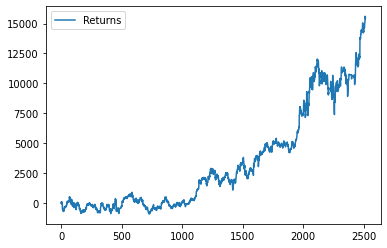

In [15]:
df_returns.plot()

<AxesSubplot:>

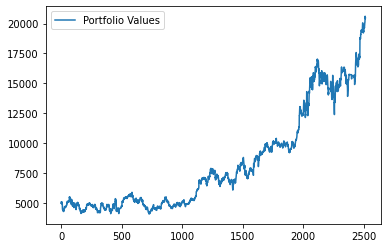

In [16]:
df_values.plot()